In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data load

In [3]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 6540 assets.


In [4]:
data.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMT,ASML,...,GRU,GSCE,GSP,HDLB,HMDCF,HOMU,HWCPZ,HAWLM,HBANP,HFRO-PA
0,125.974464,86.739708,99.687309,238.710358,485.339996,153.288055,92.300003,193.642502,191.466125,477.949158,...,3.5100,17.25,10.920,6.557615,5.1097,0.55,19.842388,15.62887,18.716362,19.115032
1,127.532021,87.636642,100.920723,240.069351,485.690002,152.861603,92.769997,194.582230,192.433868,483.072815,...,3.4950,17.25,11.430,6.720678,5.1097,0.55,19.909050,15.62887,18.716362,19.110727
2,123.239037,86.879608,100.710602,242.694153,466.309998,152.326324,90.330002,199.272491,187.359482,468.600525,...,3.5450,17.25,11.465,7.058459,5.1097,0.55,19.716475,15.62887,18.716362,19.087008
3,127.444374,87.809464,101.688164,244.983932,477.739990,153.188248,95.160004,199.930344,189.635117,479.316132,...,3.4501,17.25,11.490,7.087579,5.1097,0.55,19.894239,15.62887,18.716362,19.116274
4,128.544388,88.270248,101.971436,245.877502,485.100006,155.184143,94.580002,203.749222,193.733017,486.303741,...,3.5650,17.25,11.690,7.081756,5.1097,0.55,19.975708,15.62887,18.716362,19.026497


### Log returns

In [5]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [6]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

# 1. Аннуализация ожидаемой доходности (mu)
expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR

# 2. Аннуализация риска (sigma)
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)

# Объединяем результаты в один DataFrame
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

# Сортировка для вывода
asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
UCIX              0.025199  6.035947e-18
WARM              0.025199  6.035947e-18
VCOR              0.025199  6.035947e-18
WBHC              0.025199  6.035947e-18
MULG              0.025199  6.035947e-18

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
EOSS             -5.658339     14.391406
ELIO             -2.452975     15.135011
SECI              0.931093     18.431838
APPB             -5.661648     18.724938
NDTP             -0.296223     20.401293


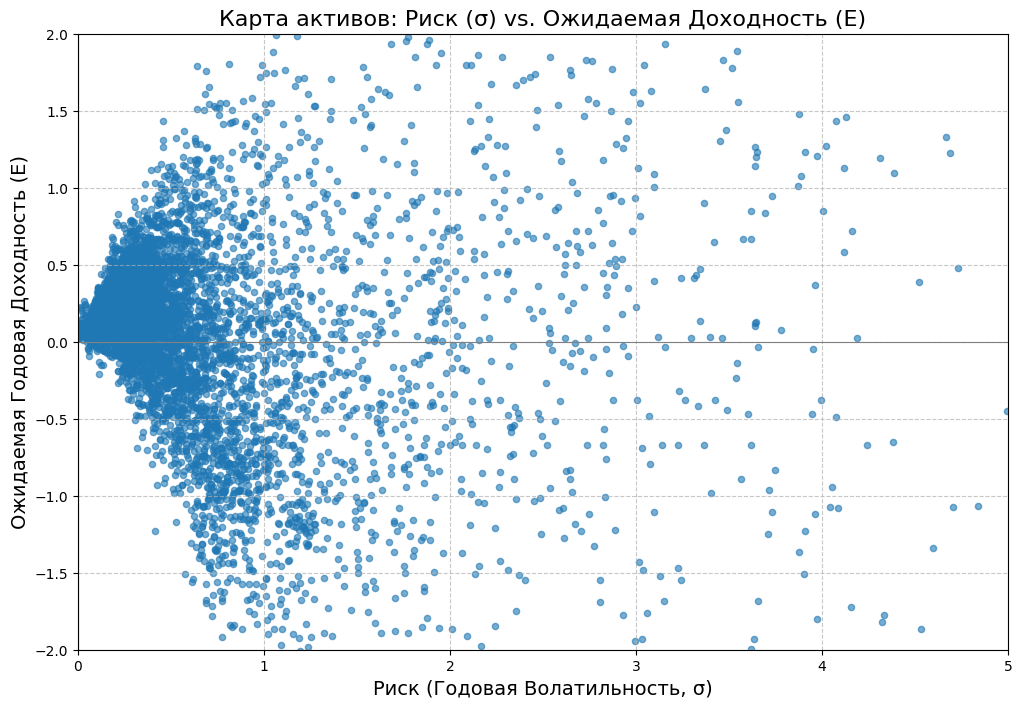

In [7]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

### Поиск Парето-оптимальных активов

In [8]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 32

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
ELLKF              0.025199  6.035947e-18
XPTFX              0.043246  6.098673e-03
CCLFX              0.123407  9.506756e-03
NICHX              0.141159  1.149543e-02
PRDEX              0.223496  1.292281e-02
FROPX              0.267259  3.546448e-02
RSF                0.281760  9.812526e-02
PIIVX              0.322518  1.052297e-01
NRSZX              0.352706  1.055189e-01
CET                0.442299  1.216275e-01


Визуализируем Парето-оптимальные активы:

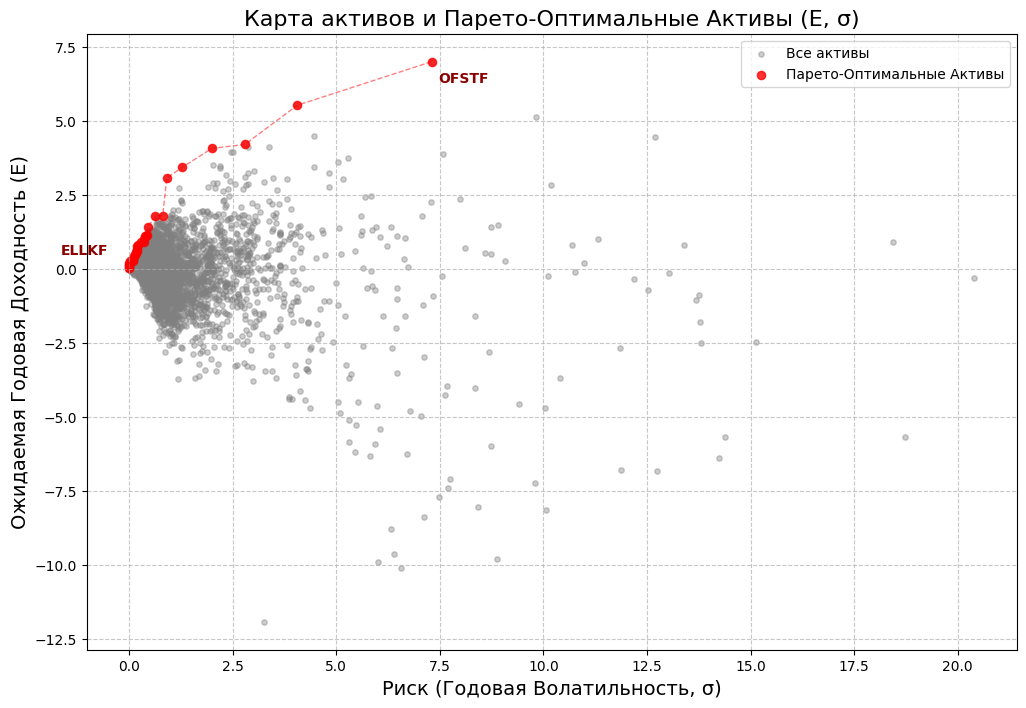

In [9]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Оценка VAR

In [10]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
ELLKF              0.025199  6.035947e-18         -0.000100          -0.001587
XPTFX              0.043246  6.098673e-03         -0.000100          -0.001587
CCLFX              0.123407  9.506756e-03         -0.000100          -0.001587
NICHX              0.141159  1.149543e-02         -0.000100          -0.001587
PRDEX              0.223496  1.292281e-02         -0.000100          -0.001587
FROPX              0.267259  3.546448e-02          0.001248           0.019817
PIIVX              0.322518  1.052297e-01          0.004458           0.070769
RSF                0.281760  9.812526e-02          0.007187           0.114098
NRSZX              0.352706  1.055189e-01          0.008387           0.133140
LTAFX              0.539107  1.641799e-01          0.008888           0.141099


In [11]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: ELLKF
Годовой VaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

Расположение на карте (σ, E):
Риск (X-координата): 0.0000
Доходность (Y-координата): 0.0252


In [12]:
data["HMDCF"].describe()

,HMDCF
count,252.0000
mean,5.1097
std,0.0000
min,5.1097
25%,5.1097
50%,5.1097
75%,5.1097
max,5.1097


Это малоликвидный актив, цена которого даже не изменилась за целый год

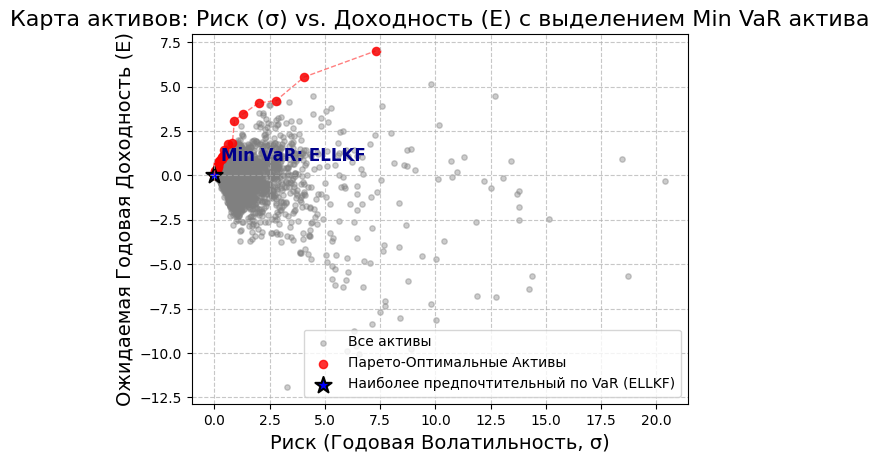

In [13]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Анализ CVaR

In [14]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
ELLKF              0.025199  6.035947e-18          -0.001587   
CCLFX              0.123407  9.506756e-03          -0.001587   
NICHX              0.141159  1.149543e-02          -0.001587   
XPTFX              0.043246  6.098673e-03          -0.001587   
PRDEX              0.223496  1.292281e-02          -0.001587   
FROPX              0.267259  3.546448e-02           0.019817   
PIIVX              0.322518  1.052297e-01           0.070769   
NRSZX              0.352706  1.055189e-01           0.133140   
LTAFX              0.539107  1.641799e-01           0.141099   
RSF                0.281760  9.812526e-02           0.114098   

       CVaR (Annual, 95%)  
ELLKF           -0.001587  
CCLFX           -0.001529  
NICHX           -0.000862  
XPTFX           -0.000838  
PRDEX           -0.000656  
FROPX            0.03686

In [15]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: ELLKF
Годовой CVaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: ELLKF
Тикер, предпочтительный по CVaR: ELLKF
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.


# Nasdaq100 analysis

Проделаем то же самое, но для более известных компаний из индекса Nasdaq100

In [37]:
try:
    data = pd.read_csv("data/processed/NASDAQ_100_2021_Cleaned.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_100_2021_Cleaned.csv not found.")

Data loaded successfully with 252 rows (days) and 100 assets.


In [38]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,"129,41","139,15","485,34","146,02","168,96","296,84","81,54","86,87","92,3","226,66",...,"229,43","41,4","30,63","228,08","65,655","196,09","0,99","6,86","0,677","2,8"
1,"131,01","148,3","485,69","148,63","168,49","301,7","81,43","89,6","92,77","227,76",...,"228,58","41,16","31,52","225,36","65,02","193,48","0,949","6,84","0,713","2,8"
2,"126,6","142,77","466,31","149,3","167,9","302,87","82,08","90,83","90,33","233,25",...,"226,65","43,03","34,25",220,"66,46","184,42","1,061","7,04","0,758","2,81"
3,"130,92","151,27","477,74","155,61","168,85","315,2","79,89","94,56","95,16","234,02",...,"232,9","45,26","34,4","226,21","65,16","193,05","1,058","7,27","0,794","2,83"
4,"132,05","149,77","485,1","156,74","171,05","319,85","79,18","95,56","94,58","238,49",...,237,"45,21","34,63","227,65","65,76","197,37","1,096","7,57","0,815","2,85"


In [39]:
data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)

/tmp/ipython-input-3109654890.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)


In [40]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,129.41,139.15,485.34,146.02,168.96,296.84,81.54,86.87,92.3,226.66,...,229.43,41.4,30.63,228.08,65.655,196.09,0.99,6.86,0.677,2.8
1,131.01,148.3,485.69,148.63,168.49,301.7,81.43,89.6,92.77,227.76,...,228.58,41.16,31.52,225.36,65.02,193.48,0.949,6.84,0.713,2.8
2,126.6,142.77,466.31,149.3,167.9,302.87,82.08,90.83,90.33,233.25,...,226.65,43.03,34.25,220,66.46,184.42,1.061,7.04,0.758,2.81
3,130.92,151.27,477.74,155.61,168.85,315.2,79.89,94.56,95.16,234.02,...,232.9,45.26,34.4,226.21,65.16,193.05,1.058,7.27,0.794,2.83
4,132.05,149.77,485.1,156.74,171.05,319.85,79.18,95.56,94.58,238.49,...,237,45.21,34.63,227.65,65.76,197.37,1.096,7.57,0.815,2.85


In [43]:
data = data.astype(float)

In [45]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [46]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
PEP               0.211622      0.145204
MDLZ              0.161003      0.158197
AEP               0.112744      0.165648
KDP               0.180086      0.175725
EXC               0.365102      0.181067

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
MDB               0.439365      0.601486
DASH              0.092917      0.651467
PDD              -1.029932      0.701593
TTD               0.195500      0.707224
MRNA              0.849591      0.803887


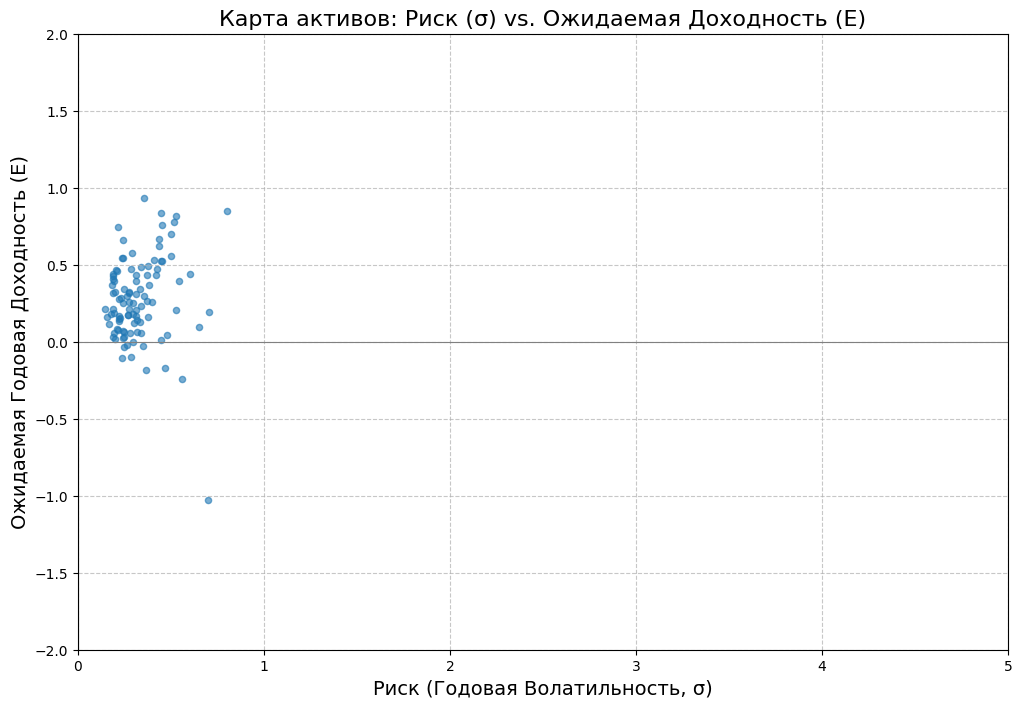

In [47]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

In [48]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 7

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
PEP                0.211622      0.145204
EXC                0.365102      0.181067
ADP                0.404693      0.187943
PAYX               0.439326      0.188155
ORLY               0.468827      0.204702
CH10Y              0.742325      0.216287
FTNT               0.932563      0.352902


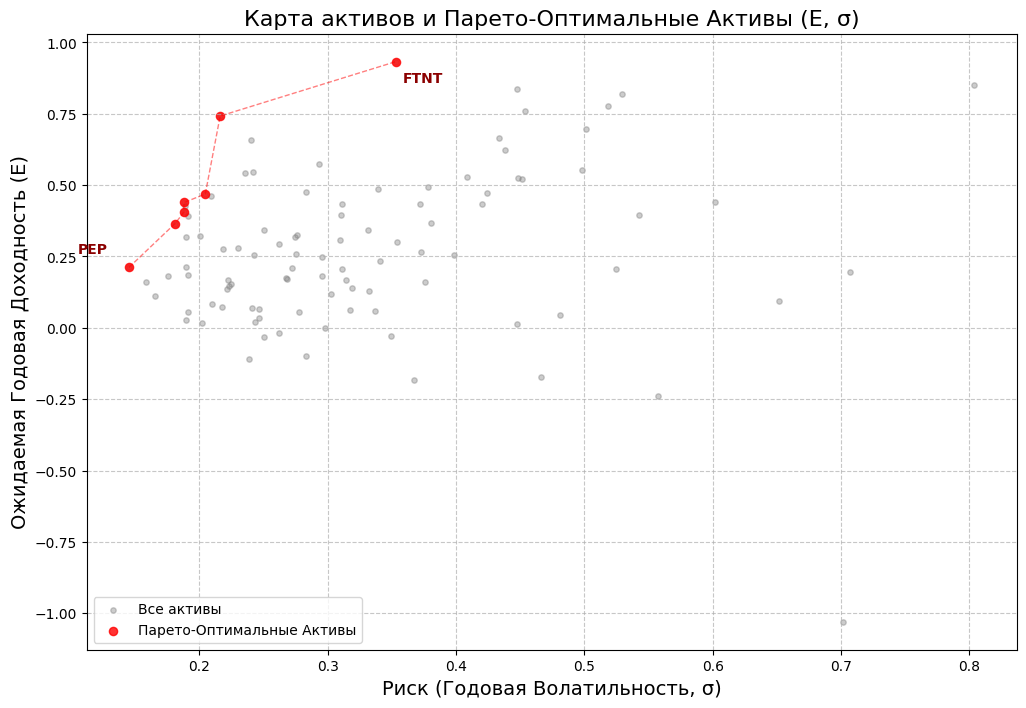

In [49]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [50]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
PEP                0.211622      0.145204          0.015773           0.250387
EXC                0.365102      0.181067          0.015817           0.251094
ORLY               0.468827      0.204702          0.016939           0.268891
PAYX               0.439326      0.188155          0.018438           0.292692
ADP                0.404693      0.187943          0.019289           0.306201
CH10Y              0.742325      0.216287          0.020502           0.325453
FTNT               0.932563      0.352902          0.035703           0.566766


In [51]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: PEP
Годовой VaR (95%): 0.2504
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

Расположение на карте (σ, E):
Риск (X-координата): 0.1452
Доходность (Y-координата): 0.2116


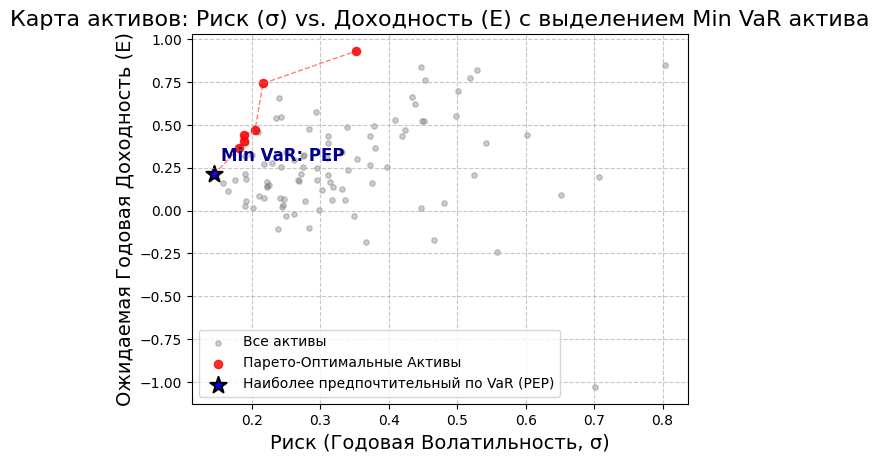

In [52]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [53]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
PEP                0.211622      0.145204           0.250387   
PAYX               0.439326      0.188155           0.292692   
ADP                0.404693      0.187943           0.306201   
EXC                0.365102      0.181067           0.251094   
ORLY               0.468827      0.204702           0.268891   
CH10Y              0.742325      0.216287           0.325453   
FTNT               0.932563      0.352902           0.566766   

       CVaR (Annual, 95%)  
PEP              0.315924  
PAYX             0.388915  
ADP              0.401941  
EXC              0.417573  
ORLY             0.460438  
CH10Y            0.465842  
FTNT             0.723307  


In [54]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: PEP
Годовой CVaR (95%): 0.3159
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: PEP
Тикер, предпочтительный по CVaR: PEP
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.
